# **Time Series Turkish Lira Unit Value Estimation with Long Short Term Memory and Gated Recurrent Unit Models**

Before we start, this notebook was made with google collaboratory. In order for the codes to work as desired, a folder called 'input' should be created in the file tab on the left side of the google collaboratory notebook page. After the folder is created, the dataset must be loaded into this folder.

## Import Libraries and Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

import time

import torch
import torch.nn as nn
!pip install pmdarima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA



from fbprophet import Prophet

import plotly.express as px
import plotly.graph_objects as go

!pip install chart-studio

import chart_studio.plotly as py
import chart_studio


This data set shows the unit value of the Turkish lira (TRY) against the US dollar (USD) in terms of time. The dataset includes data between January 1, 2013 and March 2, 2021. The data has been downloaded from the Investing.com site. This site is used by many people around the world for information and decision making before taking a financial action.

In [ ]:
# Upload Data
data = pd.read_csv('/content/input/USD_TRY Historical Data .csv')

## Exploratory Data Analysis

In [ ]:
data.head()

,Date,Price,Open,High,Low,Change %
0,"Mar 02, 2021",7.3447,7.2801,7.3645,7.2789,0.93%
1,"Mar 01, 2021",7.2769,7.4269,7.4296,7.2181,-1.96%
2,"Feb 26, 2021",7.4226,7.3418,7.4925,7.2979,1.20%
3,"Feb 25, 2021",7.3345,7.1684,7.4460,7.1537,2.37%
4,"Feb 24, 2021",7.1648,7.1068,7.2527,7.0721,0.88%


In [ ]:
data.shape

(2131, 6)

In [ ]:
data.describe()

,Price,Open,High,Low
count,2131.000000,2131.000000,2131.000000,2131.000000
mean,3.948523,3.945561,3.977506,3.919847
std,1.790317,1.790357,1.808478,1.774944
min,1.747300,1.746800,1.758700,1.742000
25%,2.341150,2.337100,2.360150,2.322400
50%,3.512800,3.512300,3.532500,3.494000
75%,5.631650,5.628000,5.691450,5.576250
max,8.520000,8.431600,8.587600,8.402300


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2131 entries, 0 to 2130
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2131 non-null   object 
 1   Price     2131 non-null   float64
 2   Open      2131 non-null   float64
 3   High      2131 non-null   float64
 4   Low       2131 non-null   float64
 5   Change %  2131 non-null   object 
dtypes: float64(4), object(2)
memory usage: 100.0+ KB


In [ ]:
data.dtypes

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Change %     object
dtype: object

We will try to estimate the current value of the Turkish lira and the chart below shows the data behavior over the years.

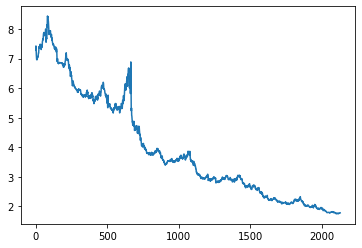

In [ ]:
dat = data.iloc[:,2:3].values
plt.plot(dat, label = 'Price')
plt.show()

### Data Transformation

In [ ]:
data['Change %'] = list(map(lambda x: x[:-1], data['Change %'].values)) # taking change column for type transformation

In [ ]:
data['Date'] = pd.to_datetime(data['Date']) # changing type from object to datetime

In [ ]:
data['Change %'] = data['Change %'].astype(float) # convert from object to float type

In [ ]:
data = data.sort_values('Date') # sorting according to datetime and showing table 
data.head()

,Date,Price,Open,High,Low,Change %
2130,2013-01-01,1.7838,1.7817,1.7850,1.7816,0.01
2129,2013-01-02,1.7787,1.7818,1.7834,1.7730,-0.29
2128,2013-01-03,1.7847,1.7780,1.7855,1.7750,0.34
2127,2013-01-04,1.7818,1.7831,1.7906,1.7798,-0.16
2126,2013-01-07,1.7798,1.7806,1.7861,1.7750,-0.11


In [ ]:
data.head()

,Date,Price,Open,High,Low,Change %
2130,2013-01-01,1.7838,1.7817,1.7850,1.7816,0.01
2129,2013-01-02,1.7787,1.7818,1.7834,1.7730,-0.29
2128,2013-01-03,1.7847,1.7780,1.7855,1.7750,0.34
2127,2013-01-04,1.7818,1.7831,1.7906,1.7798,-0.16
2126,2013-01-07,1.7798,1.7806,1.7861,1.7750,-0.11


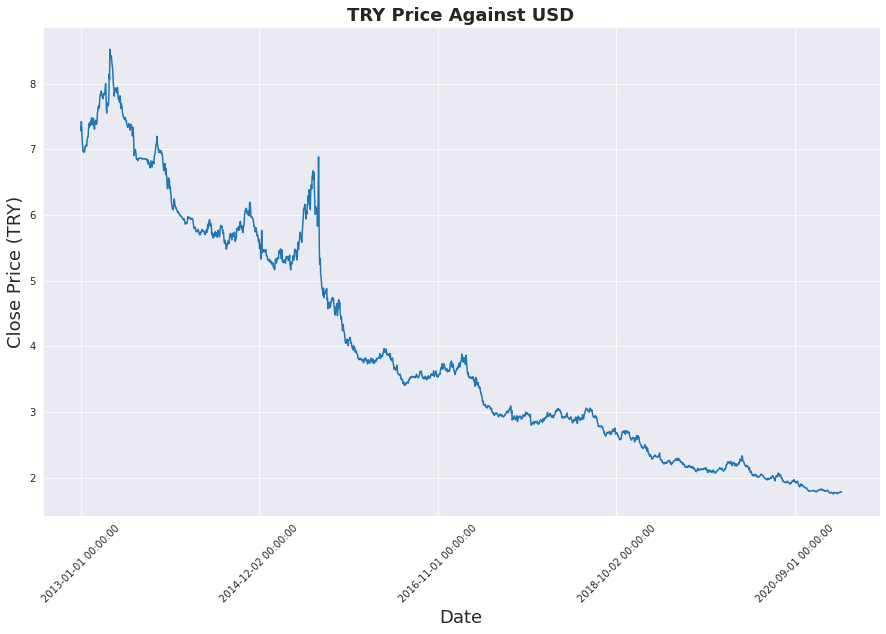

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize = (15,9))
plt.plot(data[['Price']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("TRY Price Against USD",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (TRY)',fontsize=18)
plt.show()

## Normalise Data

We sliced the dataset to get the required column and apply the normalisation process.

In [ ]:
price = data[['Price']]
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2131 entries, 2130 to 0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2131 non-null   float64
dtypes: float64(1)
memory usage: 33.3 KB


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Price'] = scaler.fit_transform(price['Price'].values.reshape(-1,1))  

## Copying Data for Seasonality and Trend

In [ ]:
data_season = data.copy() 

## Splitting Data

Now we separate the data into train and test sets. But before that we must determine the extent of the analysis. Using previous time steps to predict the next future time data is called the sliding window method.

In [ ]:
def split_data(currency, lookback):
    data_raw = currency.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [ ]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1689, 19, 1)
y_train.shape =  (1689, 1)
x_test.shape =  (422, 19, 1)
y_test.shape =  (422, 1)


## Converting to Tensors

Pytorch models take inputs as tensors. That's why we convert our attributes to tensors.

In [ ]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

We determine the common parameter values we use for both models.

## Common Parameter Determination

In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

## Seasonality

[check the link to see how we demonstrated seasonal analysis](https://medium.com/@cdabakoglu/time-series-forecasting-arima-lstm-prophet-with-python-e73a750a9887)

In [ ]:
data_season.head()

,Date,Price,Open,High,Low,Change %
2130,2013-01-01,1.7838,1.7817,1.7850,1.7816,0.01
2129,2013-01-02,1.7787,1.7818,1.7834,1.7730,-0.29
2128,2013-01-03,1.7847,1.7780,1.7855,1.7750,0.34
2127,2013-01-04,1.7818,1.7831,1.7906,1.7798,-0.16
2126,2013-01-07,1.7798,1.7806,1.7861,1.7750,-0.11


In [ ]:
data_season = data_season[['Date', 'Price']]

We are rearranging our dataset on a monthly basis.

In [ ]:
data_season.set_index('Date', inplace=True)
data_season.index = pd.to_datetime(data_season.index)
data_season.resample('1M').mean()

,Price
Date,
2013-01-31,1.770617
2013-02-28,1.778255
2013-03-31,1.808476
2013-04-30,1.796359
2013-05-31,1.826930
...,...
2020-11-30,7.959905
2020-12-31,7.691183
2021-01-31,7.395790


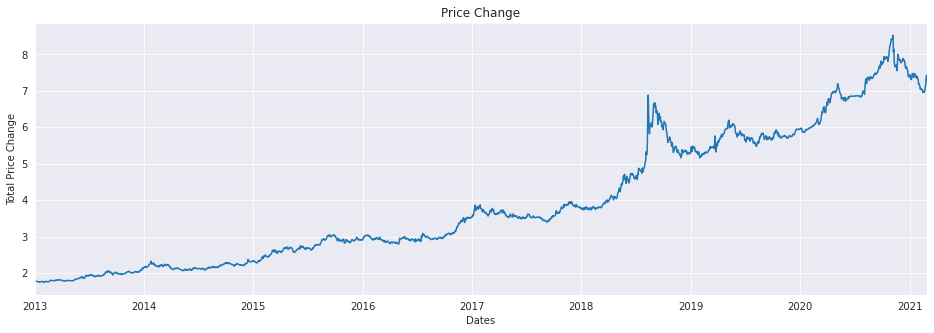

In [ ]:
data_season.index.freq = 'B'
ax = data_season['Price'].plot(figsize = (16,5), title = "Price Change")
ax.set(xlabel='Dates', ylabel='Total Price Change');

Above chart shows that mounthly frequency by year

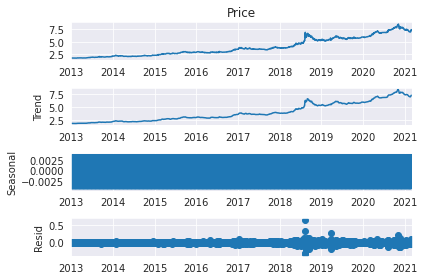

In [ ]:
a = seasonal_decompose(data_season["Price"], model = "add")
a.plot();

Trend, Resid and Seasonal analysis showed up with seasonal_decompose algorithm

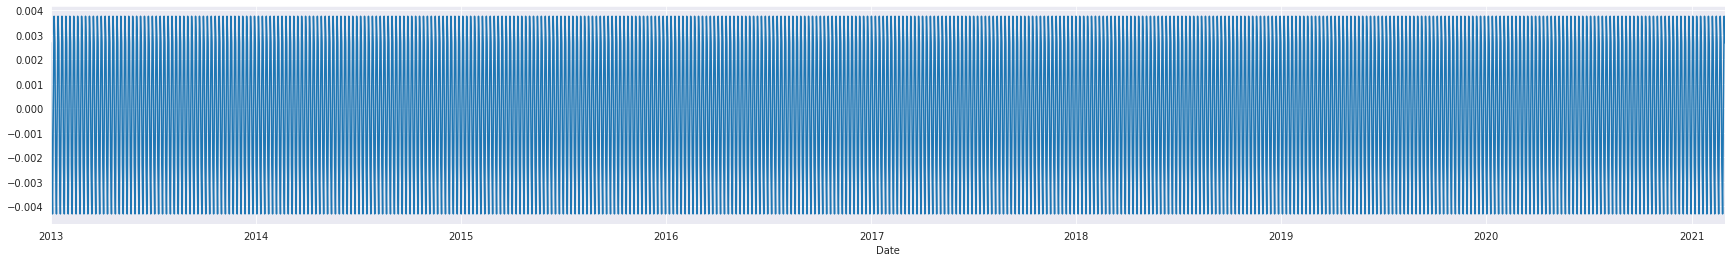

In [ ]:
plt.figure(figsize = (30,4))
a.seasonal.plot();

### Arima Forecast

In [ ]:
auto_arima(data_season['Price'], seasonal=False, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2131
Model:               SARIMAX(2, 1, 3)   Log Likelihood                3469.512
Date:                Wed, 07 Apr 2021   AIC                          -6925.024
Time:                        21:12:20   BIC                          -6885.377
Sample:                             0   HQIC                         -6910.513
                               - 2131                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.002      2.289      0.022       0.001       0.007
ar.L1         -0.0343      0.057     -0.605      0.545      -0.145       0.077
ar.L2         -0.3717      0.069     -5.388      0.000      -0.507      -0.236
ma.L1          0.1766      0.057      3.086      0.002       0.064       0.289
ma.L2          0.3148      0.070      4.473      0.000       0.177       0.453
ma.L3         -0.1118      0.016     -6.895      0.000      -0.144      -0.080
sigma2         0.0023   1.93e-05    116.499      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            286493.69
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              21.36   Skew:                             1.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        59.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As we can see best arima model chosen by auto_arima() is SARIMAX(2, 1, 3)

Let’s split the data into train and test set.(Note: We don't see any sign of seasonality so we used ARIMA instead of SARIMAX)

In [ ]:
train_data = data_season[:len(data_season)-12]
test_data = data_season[len(data_season)-12:]
arima_model = ARIMA(train_data['Price'], order = (2,1,3))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 2119
Model:                 ARIMA(2, 1, 3)   Log Likelihood                3460.976
Date:                Wed, 07 Apr 2021   AIC                          -6909.952
Time:                        21:12:22   BIC                          -6876.003
Sample:                    01-01-2013   HQIC                         -6897.523
                         - 02-12-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0363      0.054     -0.677      0.499      -0.142       0.069
ar.L2         -0.3814      0.067     -5.707      0.000      -0.512      -0.250
ma.L1          0.1817      0.054      3.381      0.001       0.076       0.287
ma.L2          0.3268      0.068      4.775      0.000       0.193       0.461
ma.L3         -0.1122      0.016     -7.067      0.000      -0.143      -0.081
sigma2         0.0022    1.9e-05    117.088      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            299929.52
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              21.00   Skew:                             1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        61.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arima_pred = arima_result.predict(start = len(train_data), end = len(data_season)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2021-02-15    7.039074
2021-02-16    7.041177
2021-02-17    7.037246
2021-02-18    7.036587
2021-02-19    7.038110
2021-02-22    7.038306
2021-02-23    7.037718
2021-02-24    7.037664
2021-02-25    7.037891
2021-02-26    7.037903
2021-03-01    7.037816
2021-03-02    7.037815
Freq: B, Name: ARIMA Predictions, dtype: float64

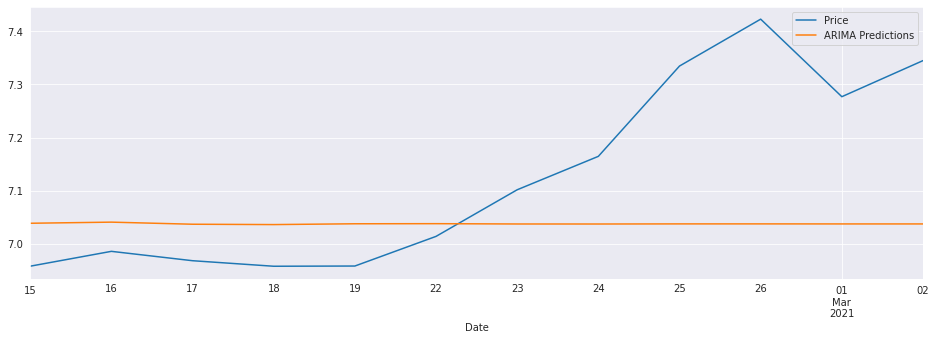

In [ ]:
test_data['Price'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [ ]:
arima_rmse_error = rmse(test_data['Price'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = data_season['Price'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 0.03623576271504145
RMSE Error: 0.19035693503269444
Mean: 3.9485233693101844


In [ ]:
test_data['ARIMA_Predictions'] = arima_pred

### Prophet Forecast

In [ ]:
data_season.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2131 entries, 2013-01-01 to 2021-03-02
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2131 non-null   float64
dtypes: float64(1)
memory usage: 33.3 KB


In [ ]:
df_pr = data_season.copy()
df_pr = data_season.reset_index()
df_pr.columns = ['ds','y'] # To use prophet column names should be like that
train_data_pr = df_pr.iloc[:len(data_season)-12]
test_data_pr = df_pr.iloc[len(data_season)-12:] 
m = Prophet() # creating prophet model
m.fit(train_data_pr) # fitting model
future = m.make_future_dataframe(periods=12,freq='MS') 
prophet_pred = m.predict(future) # predicting future values
prophet_pred.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2126,2021-10-01,8.823140,8.406452,9.404010,8.398838,9.267873,0.094743,0.094743,0.094743,0.000188,0.000188,0.000188,0.094555,0.094555,0.094555,0.0,0.0,0.0,8.917883
2127,2021-11-01,8.949225,8.435780,9.606639,8.430123,9.520942,0.044746,0.044746,0.044746,0.002259,0.002259,0.002259,0.042488,0.042488,0.042488,0.0,0.0,0.0,8.993971
2128,2021-12-01,9.071243,8.330758,9.725079,8.466790,9.720583,-0.042778,-0.042778,-0.042778,-0.002809,-0.002809,-0.002809,-0.039969,-0.039969,-0.039969,0.0,0.0,0.0,9.028465
2129,2022-01-01,9.197328,8.314604,9.927812,8.457366,9.971683,-0.080347,-0.080347,-0.080347,0.001662,0.001662,0.001662,-0.082010,-0.082010,-0.082010,0.0,0.0,0.0,9.116981
2130,2022-02-01,9.323414,8.338836,10.139884,8.452933,10.234625,-0.122960,-0.122960,-0.122960,0.001696,0.001696,0.001696,-0.124656,-0.124656,-0.124656,0.0,0.0,0.0,9.200454


In [ ]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]}) # converting dataframe
prophet_pred = prophet_pred.set_index("Date") 
prophet_pred.index.freq = "MS" # group by monthly mean values
prophet_pred

,Pred
Date,
2021-03-01,7.905846
2021-04-01,8.069879
2021-05-01,8.257866
2021-06-01,8.343392
2021-07-01,8.413528
2021-08-01,8.541705
2021-09-01,8.843067
2021-10-01,8.917883
2021-11-01,8.993971


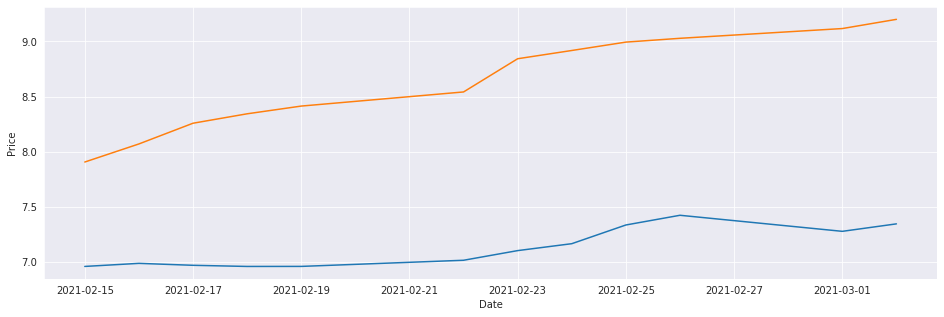

In [ ]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["Price"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

In [ ]:
prophet_rmse_error = rmse(test_data['Price'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = data_season['Price'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 2.3640327479866623
RMSE Error: 1.537541137006312
Mean: 3.9485233693101844


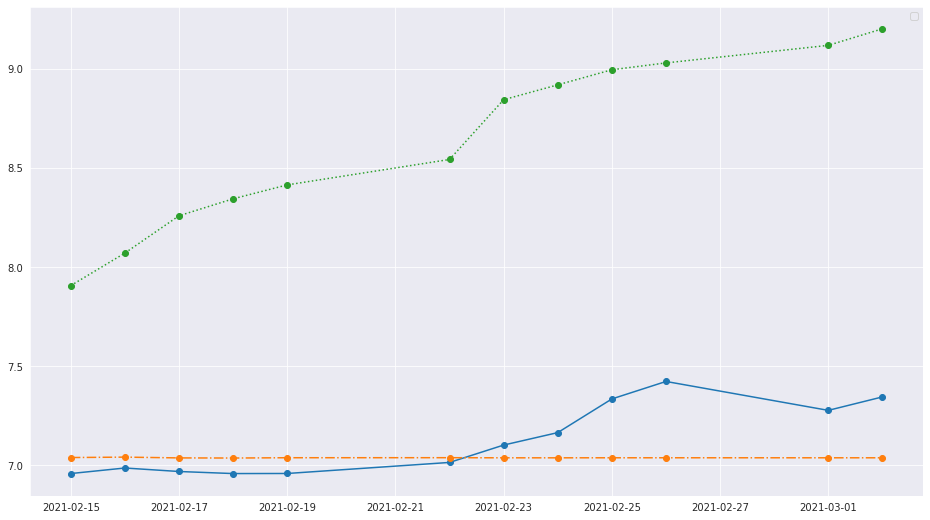

In [ ]:
rmse_errors = [arima_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["Price"], linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()

Orange is ARIMA, Blue is real values and Green for the Prophet.

In [ ]:
print(f"Mean: {test_data['Price'].mean()}")
errors

Mean: 7.124191666666667


,Models,RMSE Errors,MSE Errors
0,ARIMA,0.190357,0.036236
1,Prophet,1.537541,2.364033


## **LSTM Model Creation**


We have defined our LSTM model and optimizer.

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

We trained our model over 100 epochs.

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.5501375198364258
Epoch  1 MSE:  0.40467146039009094
Epoch  2 MSE:  0.27649226784706116
Epoch  3 MSE:  0.14959275722503662
Epoch  4 MSE:  0.13542450964450836
Epoch  5 MSE:  0.16158337891101837
Epoch  6 MSE:  0.11722859740257263
Epoch  7 MSE:  0.1016748696565628
Epoch  8 MSE:  0.1068955510854721
Epoch  9 MSE:  0.11043322831392288
Epoch  10 MSE:  0.10418251156806946
Epoch  11 MSE:  0.08880088478326797
Epoch  12 MSE:  0.06967799365520477
Epoch  13 MSE:  0.057200681418180466
Epoch  14 MSE:  0.06023108586668968
Epoch  15 MSE:  0.05551103502511978
Epoch  16 MSE:  0.03276456147432327
Epoch  17 MSE:  0.021719852462410927
Epoch  18 MSE:  0.024967888370156288
Epoch  19 MSE:  0.021855205297470093
Epoch  20 MSE:  0.009277435019612312
Epoch  21 MSE:  0.010812319815158844
Epoch  22 MSE:  0.019282370805740356
Epoch  23 MSE:  0.014031512662768364
Epoch  24 MSE:  0.009879188612103462
Epoch  25 MSE:  0.012126985937356949
Epoch  26 MSE:  0.011164044961333275
Epoch  27 MSE:  0.006504317279

We transforming numpy arrays to dataframe for prediction and orjinal values.

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

After your training process was completed, we performed the visualization process in order to make predictions with our test data and to see the results better.

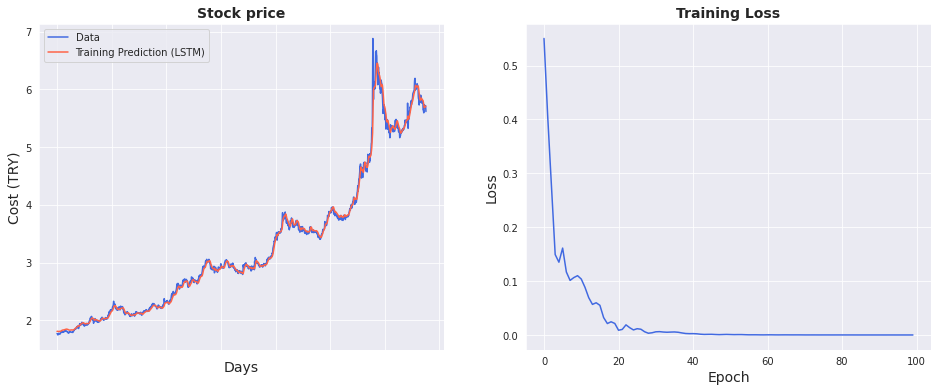

In [ ]:
# sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (TRY)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 0.08 RMSE
Test Score: 0.34 RMSE


In [ ]:
# shift train predictions for plotting with Plotly
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting with Plotly
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Price'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result1 = pd.DataFrame(predictions)

We visualized our model results with the help of plotly. [Plotly charts](https://chart-studio.plotly.com/)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result1.index, y=result1[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result1.index, y=result1[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result1.index, y=result1[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (TRY)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [ ]:
# chart_studio.tools.set_credentials_file(username='your name', api_key='your key')
# py.iplot(fig, filename='Currency_Prediction')

Although our model looks quite successful with the training set, it does not perform that well in the test data set. Probably overfitting.

**Can we use cross validation on time series ?**

In [ ]:
# pip install -U skorch

In [ ]:
# from skorch import NeuralNetRegressor

In [ ]:
# Can we use cross validation on time series data ?
# generate skorch high-level regressor and perform 5-fold cross validation using cross_val_score()
# logistic = NeuralNetRegressor(model, max_epochs = 10, lr = 1e-2)
# scores = cross_val_score(logistic, x_train, y_train, cv = 5, scoring = "accuracy")

## **GRU Model Creation**

The GRU modeling process is very similar to the LSTM modeling process.

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

If our model is overfit or underfit, we must make our model suitable by entering parameters into the optimizer algorithm. 

[Check the link](https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch)

[check this too :)](https://pytorch.org/docs/stable/optim.html)





In [ ]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean') # error metric
optimiser = torch.optim.Adam(model.parameters(), lr=0.01) # Adam optimizer with default parameters (For fair comparison with LSTM)

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time() # for the calculate processing time
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward() # backpropagation
    optimiser.step()
    
training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.41224297881126404
Epoch  1 MSE:  0.1500653773546219
Epoch  2 MSE:  0.09946569800376892
Epoch  3 MSE:  0.14074721932411194
Epoch  4 MSE:  0.0901271179318428
Epoch  5 MSE:  0.06703949719667435
Epoch  6 MSE:  0.07467762380838394
Epoch  7 MSE:  0.07467810064554214
Epoch  8 MSE:  0.056713856756687164
Epoch  9 MSE:  0.03275896608829498
Epoch  10 MSE:  0.021168403327465057
Epoch  11 MSE:  0.026191065087914467
Epoch  12 MSE:  0.02318989858031273
Epoch  13 MSE:  0.0071161831729114056
Epoch  14 MSE:  0.0013632165500894189
Epoch  15 MSE:  0.011638562195003033
Epoch  16 MSE:  0.017522145062685013
Epoch  17 MSE:  0.011474576778709888
Epoch  18 MSE:  0.006275916006416082
Epoch  19 MSE:  0.00832255370914936
Epoch  20 MSE:  0.008716698735952377
Epoch  21 MSE:  0.004093439318239689
Epoch  22 MSE:  0.0009120876202359796
Epoch  23 MSE:  0.0022186001297086477
Epoch  24 MSE:  0.004983088932931423
Epoch  25 MSE:  0.0058202240616083145
Epoch  26 MSE:  0.0044425129890441895
Epoch  27 MSE:  0.

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

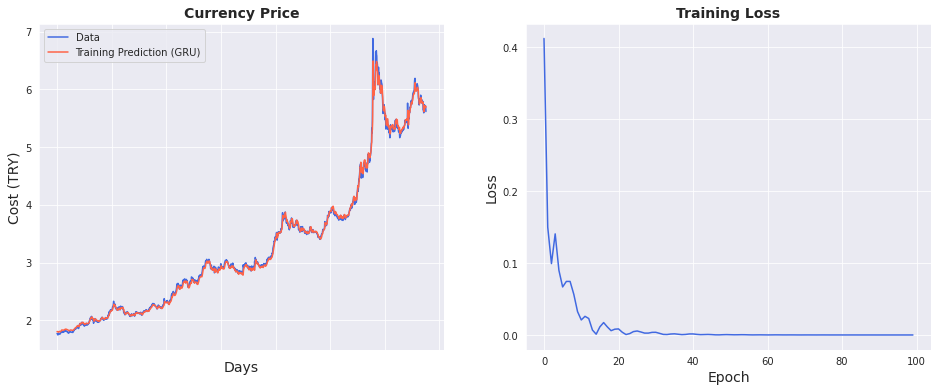

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Currency Price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (TRY)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

The part of training our model is exactly the same, and it looks quite similar in the results we got.

In [ ]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 0.06 RMSE
Test Score: 0.31 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Price'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (TRY)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In terms of estimation, the GRU model gives a better result than the LSTM model. At the same time, it can make estimates in a shorter time.

In [ ]:
# py.iplot(fig, filename='stock_prediction_gru')

We collect the models on a single chart.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result1[0],
                    mode='lines',
                    name='(LSTM)Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result1[1],
                    mode='lines',
                    name='(LSTM)Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='(GRU)Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='(GRU)Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (TRY)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM and GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

## **Results**

In [ ]:
lstm = pd.DataFrame(lstm, columns=['LSTM'])
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([lstm, gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,LSTM,GRU
Train RMSE,0.077114,0.057223
Test RMSE,0.339158,0.307565
Train Time,20.240969,15.804742


According to above chart, GRU model performace much better tha LSTM model. 

In [ ]:
!pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
astor==0.8.1
astropy==4.2
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.0
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.1
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
chainer==7.4.0
chardet==3.0.4
chart-studio==1.1.0
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.17
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
dlib==19.18.0
dm-tree==0.1.5
docopt==0.6.2
do